# BIO 265 Final Project - Lily Kalcec, Pre Lavania, and Nicole Haseley

In [1]:
# 1 Import libraries
# standard libraries
import os
import pandas as pd
import numpy as np 
import scipy
from matplotlib import pyplot as plt

# differential expression
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

# dimentionality reduction and clustering
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import umap

from statsmodels.stats.multitest import multipletests

c:\ProgramData\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
# 2 Load in data (final RNAseq readcounts)
RNAseq_data = pd.read_csv("rawcounts-final.csv")
RNAseq_data.drop("ensemble_id_version", axis=1, inplace=True)

In [9]:
RNAseq_data

,CFB2001,CFB2006,CFB2007,CFB2009,CFB2013,CFB2022,CFB2039,CFB2044,CFB2045,CFB2049,...,CFB2146,CFB2149,CFB2152,CFB2159,CFB2160,CFB2163,CFB2166,CFB2169,CFB2171,CFB2186
0,1,4,30,15,4,7,23,19,15,15,...,24,12,14,12,16,7,20,23,20,23
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,741,260,681,1110,640,754,965,1107,906,1105,...,1000,680,533,799,1441,705,1000,1452,1140,1875
3,881,293,782,1013,581,587,884,770,711,1049,...,882,603,512,560,1240,619,763,1504,1011,1421
4,64,30,71,102,72,89,121,124,83,122,...,122,76,40,78,157,85,116,130,117,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60644,14,13,25,38,12,21,23,34,26,36,...,27,20,12,10,28,27,27,45,35,44
60645,2511,1032,2328,2841,3197,1091,3035,1812,1845,3294,...,1773,1722,728,1649,3436,2090,1497,4886,2635,2789
60646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60647,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Processing

In [3]:
# 3 separate the samples into control and test (have ntm disease) groups
control_samples = ["CFB2006", "CFB2007", "CFB2009", "CFB2013", "CFB2022", "CFB2039", "CFB2044", "CFB2058", 
                  "CFB2059", "CFB2074", "CFB2075", "CFB2082", "CFB2087", "CFB2088", "CFB2102", "CFB2108", 
                  "CFB2112", "CFB2127", "CFB2134", "CFB2138", "CFB2140", "CFB2142", "CFB2146", "CFB2149", 
                   "CFB2152", "CFB2160", "CFB2166", "CFB2169", "CFB2171", "CFB2186"] 
ntm_samples = ["CFB2001", "CFB2045", "CFB2049", "CFB2060", "CFB2061", "CFB2071", "CFB2084", "CFB2098",
              "CFB2105", "CFB2128", "CFB2159", "CFB2163"]

In [4]:
# 4
# create a dictionary mapping each sample to its condition
metadata_dict = {sample: "Control" for sample in control_samples}
metadata_dict.update({sample: "NTM" for sample in ntm_samples})

# convert to dataframe
metadata = pd.DataFrame.from_dict(metadata_dict, orient="index", columns=["condition"])

# ensure the index matches the column names of count_data
metadata.index.name = "sample"

In [5]:
# 5
metadata = metadata.loc[RNAseq_data.columns]

In [6]:
# 6
metadata['condition'] = metadata['condition'].astype(str)

In [7]:
# 7
# initialize PyDESeq2 model
dds = DeseqDataSet(
    counts=RNAseq_data.T,  # PyDESeq2 expects samples as rows, genes as columns
    metadata=metadata,
    design_factors=["condition"],  # Needs to be a list
    ref_level="Control"  # Setting "Control" as the reference group
)

# run DESeq2 analysis
dds.deseq2()

# extract results
res = DeseqStats(dds, contrast=["condition", "Control", "NTM"])
res.summary()

# get the results as a DataFrame
DE_results_df = res.results_df
display(DE_results_df.head())

C:\Users\Nicole\AppData\Roaming\Python\Python312\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\Nicole\AppData\Local\Temp\ipykernel_18972\2743164571.py:3: DeprecationWarning: ref_level is deprecated and no longer has any effect. It will beremoved in a future release.
  dds = DeseqDataSet(
C:\Users\Nicole\AppData\Local\Temp\ipykernel_18972\2743164571.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.54 seconds.

Fitting dispersions...
... done in 18.51 seconds.

Fitting dispersion trend curve...
... done in 3.55 seconds.

Fitting MAP dispersions...
... done in 23.10 seconds.

Fitting LFCs...
... done in 14.38 seconds.

Calculating cook's distance...
... done in 0.25 seconds.

Replacing 134 outlier genes.

Fitting dispersions...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 0.18 seconds.

Fitting LFCs...
... done in 0.21 seconds.

Running Wald tests...
... done in 13.48 seconds.



Log2 fold change & Wald test p-value: condition Control vs NTM
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0        12.518092        0.597295  0.232072  2.573747  0.010060  0.908849
1         0.000000             NaN       NaN       NaN       NaN       NaN
2       940.247914       -0.081781  0.097143 -0.841863  0.399864  0.999805
3       762.052509       -0.092727  0.071148 -1.303305  0.192471  0.999805
4        91.921074        0.026112  0.082524  0.316420  0.751684  0.999805
...            ...             ...       ...       ...       ...       ...
60644    24.857644       -0.260335  0.149527 -1.741052  0.081674  0.995673
60645  2028.061559       -0.228472  0.186265 -1.226593  0.219976  0.999805
60646     0.071146       -0.222838  3.376217 -0.066002  0.947376  0.999805
60647     0.033181        0.116997  3.394488  0.034467  0.972505  0.999805
60648     0.172063       -1.793906  3.301406 -0.543376  0.586871  0.999805

[60649 rows x 6 columns]


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,12.518092,0.597295,0.232072,2.573747,0.010060,0.908849
1,0.000000,NaN,NaN,NaN,NaN,NaN
2,940.247914,-0.081781,0.097143,-0.841863,0.399864,0.999805
3,762.052509,-0.092727,0.071148,-1.303305,0.192471,0.999805
4,91.921074,0.026112,0.082524,0.316420,0.751684,0.999805


# Benjamini-hochberg (BH) correction - shows no significant genes in unfiltered data

C:\Users\Nicole\AppData\Local\Temp\ipykernel_18972\551326653.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_results_df['log_pvalue'] = -np.log10(pvals)
C:\Users\Nicole\AppData\Local\Temp\ipykernel_18972\551326653.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_results_df['significant'] = DE_results_df["pvalue"] <= bh_cutoff


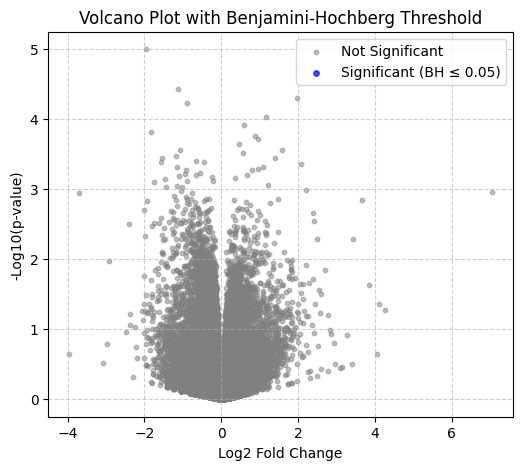

Benjamini-Hochberg threshold: None


In [8]:
# 8 - Volcano plot with benjamini hochberg threshold
# Set FDR threshold
alpha = .3 # same as theirs

# Remove NaN p-values
DE_results_df = DE_results_df.dropna(subset=['pvalue'])

# Extract p-values (after NaN removal)
pvals = DE_results_df["pvalue"].values

# Compute -log10(p-values)
DE_results_df['log_pvalue'] = -np.log10(pvals)

# Sort p-values in ascending order for BH correction
sorted_pvals = np.sort(pvals)
m = len(sorted_pvals)  # Total number of tests

# Compute BH threshold
bh_thresholds = (np.arange(1, m + 1) / m) * alpha
bh_cutoff_idx = np.where(sorted_pvals <= bh_thresholds)[0]

# Determine the BH cutoff (largest p-value satisfying the condition)
bh_cutoff = sorted_pvals[bh_cutoff_idx[-1]] if len(bh_cutoff_idx) > 0 else None  

# Determine significance: Significant if p-value is below BH cutoff
DE_results_df['significant'] = DE_results_df["pvalue"] <= bh_cutoff

# Convert p-values to -log10 scale for plotting
neg_log_pvals = DE_results_df['log_pvalue']

# Create volcano plot
plt.figure(figsize=(6, 5))

# Plot non-significant genes in gray
plt.scatter(
    DE_results_df["log2FoldChange"][~DE_results_df["significant"]],
    neg_log_pvals[~DE_results_df["significant"]],
    c='gray', alpha=0.5, s=10, label="Not Significant")

# Plot significant genes in blue
plt.scatter(
    DE_results_df["log2FoldChange"][DE_results_df["significant"]],
    neg_log_pvals[DE_results_df["significant"]],
    c='blue', alpha=0.7, s=15, label="Significant (BH ≤ 0.05)")

# Add BH threshold horizontal line (only if significant genes exist)
if bh_cutoff is not None:
    plt.axhline(y=-np.log10(bh_cutoff), color='blue', linestyle='--', linewidth=1.5, label="BH Cutoff")

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano Plot with Benjamini-Hochberg Threshold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Print threshold for significant genes
significant_threshold = np.max(sorted_pvals[sorted_pvals <= bh_thresholds]) if np.any(sorted_pvals <= bh_thresholds) else None
print(f"Benjamini-Hochberg threshold: {significant_threshold}")

In [ ]:
# 8.1
##### 03/09/25 - Loadin their DESeq dataset (filtered) #####
# to do: need to look into what Padj is on DESeq. I assume it is some type of multiple hypothesis correction. It is: padj is BH. But, they do not plot this--they plot pvalue. (i looked at their r script)

Their_DESeq_counts_data = pd.read_csv("GSE205161_20220525-geo_deseq_counts.csv.gz", compression='gzip')
Their_DESeq_counts_data.drop("ensemble_id", axis=1, inplace=True)


# No BH correction, but instead applying an arbitrary **p-value cutoff of 0.001** for signficantly differentially expressed genes (as authors did)

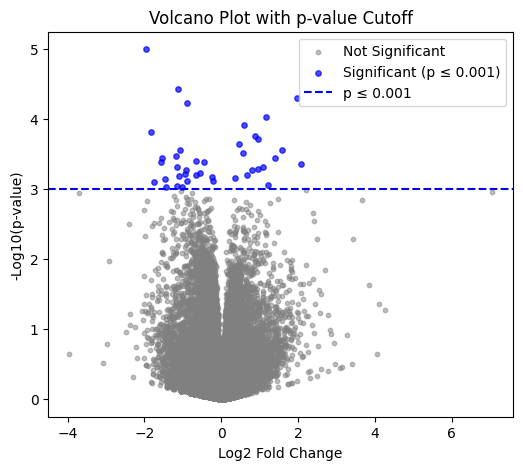

Number of significant genes (p-value ≤ 0.001): 40


In [13]:
# 9
# Set p-value threshold and log2 fold-change threshold
pvalue_cutoff = 0.001

# Remove NaN p-values and create a new DataFrame copy
DE_results_df = DE_results_df.dropna(subset=['pvalue']).copy()

# Compute -log10(p-values)
DE_results_df.loc[:, 'log_pvalue'] = -np.log10(DE_results_df["pvalue"])

# Flag significant genes based only on the p-value threshold
DE_results_df.loc[:, 'significant'] = DE_results_df["pvalue"] <= pvalue_cutoff

# Convert p-values to -log10 scale for plotting
neg_log_pvals = DE_results_df['log_pvalue']

# Create volcano plot
plt.figure(figsize=(6, 5))

# Plot non-significant genes in gray
plt.scatter(
    DE_results_df["log2FoldChange"][~DE_results_df["significant"]],
    neg_log_pvals[~DE_results_df["significant"]],
    c='gray', alpha=0.5, s=10, label="Not Significant"
)

# Plot significant genes in blue
plt.scatter(
    DE_results_df["log2FoldChange"][DE_results_df["significant"]],
    neg_log_pvals[DE_results_df["significant"]],
    c='blue', alpha=0.7, s=15, label="Significant (p ≤ 0.001)"
)

# Add p-value threshold horizontal line
plt.axhline(y=-np.log10(pvalue_cutoff), color='blue', linestyle='--', linewidth=1.5, label="p ≤ 0.001")

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano Plot with p-value Cutoff")
plt.legend()
plt.show()

# Print the p-value threshold for significant genes
significant_genes_count2 = DE_results_df[DE_results_df['pvalue'] < 0.001]
print(f"Number of significant genes (p-value ≤ {0.001}): {len(significant_genes_count2)}")

# No BH correction, but instead applying an arbitrary **p-value cutoff of 0.05** for signficantly differentially expressed genes

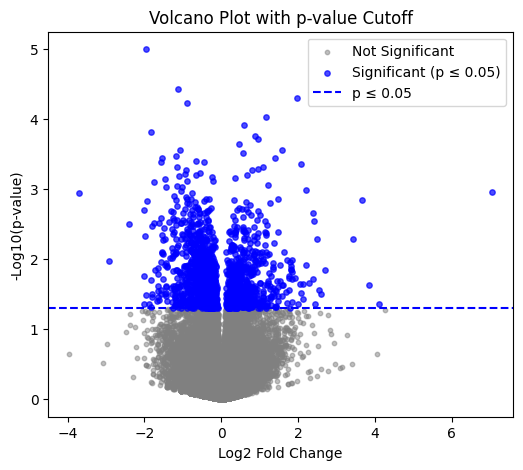

Number of significant genes (p-value ≤ 0.05): 1963


In [14]:
# 10
# Set p-value threshold and log2 fold-change threshold
pvalue_cutoff_2 = 0.05

# Remove NaN p-values and create a new DataFrame copy
DE_results_df = DE_results_df.dropna(subset=['pvalue']).copy()

# Compute -log10(p-values)
DE_results_df.loc[:, 'log_pvalue'] = -np.log10(DE_results_df["pvalue"])

# Flag significant genes based only on the p-value threshold
DE_results_df.loc[:, 'significant'] = DE_results_df["pvalue"] <= pvalue_cutoff_2

# Convert p-values to -log10 scale for plotting
neg_log_pvals = DE_results_df['log_pvalue']

# Create volcano plot
plt.figure(figsize=(6, 5))

# Plot non-significant genes in gray
plt.scatter(
    DE_results_df["log2FoldChange"][~DE_results_df["significant"]],
    neg_log_pvals[~DE_results_df["significant"]],
    c='gray', alpha=0.5, s=10, label="Not Significant"
)

# Plot significant genes in blue
plt.scatter(
    DE_results_df["log2FoldChange"][DE_results_df["significant"]],
    neg_log_pvals[DE_results_df["significant"]],
    c='blue', alpha=0.7, s=15, label="Significant (p ≤ 0.05)"
)

# Add p-value threshold horizontal line
plt.axhline(y=-np.log10(pvalue_cutoff_2), color='blue', linestyle='--', linewidth=1.5, label="p ≤ 0.05")

# Labels and title
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(p-value)")
plt.title("Volcano Plot with p-value Cutoff")
plt.legend()
plt.show()

# Print the p-value threshold for significant genes
significant_genes_count3 = DE_results_df[DE_results_df['pvalue'] < 0.05]
print(f"Number of significant genes (p-value ≤ {0.05}): {len(significant_genes_count3)}")

# P value analysis/stats in the unfiltered data

In [15]:
# 11
# # Inspect p-values and distribution
print(DE_results_df['pvalue'].describe())  # Summary of the adjusted p-values

# Check how many values are below threshold
significant_genes_count = DE_results_df[DE_results_df['pvalue'] < 0.01]
print(f"Number of significant genes (p-value ≤ {0.01}): {len(significant_genes_count)}")

count    37296.000000
mean         0.592378
std          0.329017
min          0.000010
25%          0.287806
50%          0.653645
75%          0.918878
max          0.999982
Name: pvalue, dtype: float64
Number of significant genes (p-value ≤ 0.01): 387


['NTM', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'NTM', 'NTM', 'Control', 'Control', 'NTM', 'NTM', 'NTM', 'Control', 'Control', 'Control', 'NTM', 'Control', 'Control', 'NTM', 'Control', 'NTM', 'Control', 'Control', 'Control', 'NTM', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'Control', 'NTM', 'Control', 'NTM', 'Control', 'Control', 'Control', 'Control']
            PC1           PC2           PC3            PC4            PC5  \
0 -1.059696e+06  4.951629e+05  5.405992e+05   12049.565419 -345417.188027   
1  3.112132e+06  5.247355e+06  2.861348e+06 -147465.407031   15022.684058   
2  3.288841e+06 -1.823099e+06 -4.269111e+05  -49133.061449   50213.987191   
3  2.446607e+06 -8.347330e+05 -2.706725e+05   41075.182556  -83424.867402   
4 -5.655220e+06 -1.495112e+04 -9.746742e+04   79987.696560 -267626.593160   

            PC6            PC7            PC8            PC9          PC10  
0 -10279.690058 -139122.116609   -2942.957244

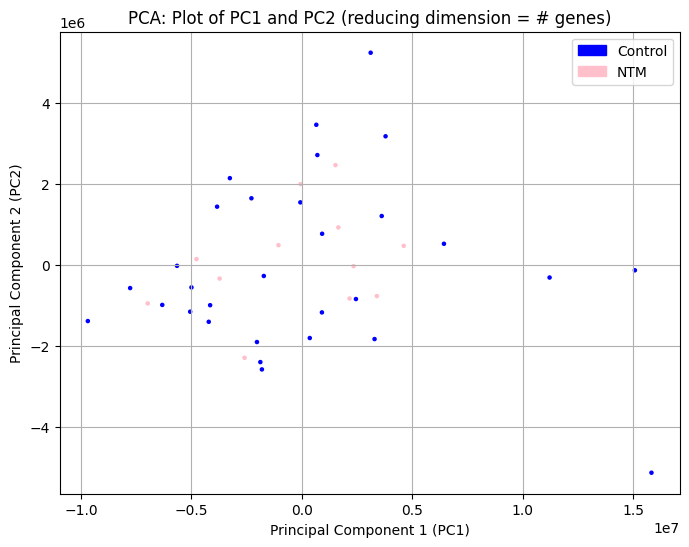

In [ ]:
# 13.1
##### 03/09/25 - PCA PLOT WHERE THE DIMENSION WE ARE REDUCING IS THE COUNTS PER GENE.
##### Aka, the subset of components we are keeping is a subset of GENES (with the numerical variable being the gene count.)

# Transposing data so that we reduce the desired dimension (genes), and keep our all of our samples (patients).
RNAseq_data_t = RNAseq_data.transpose()

# making useful list of CONTROL or NTM in order that samples come in data frame (for labelling purposes).
# Also adding colors, for labeling purposes.

ordered_list_of_control_vs_ntm_samples = []
ordered_list_of_sample_names = RNAseq_data.columns.tolist()
colors_by_sample_type = []

for i in range(0, len(RNAseq_data_t)):
    if ordered_list_of_sample_names[i] in control_samples:
        ordered_list_of_control_vs_ntm_samples.append("Control")
        colors_by_sample_type.append("Blue")

    elif ordered_list_of_sample_names[i] in ntm_samples:
        ordered_list_of_control_vs_ntm_samples.append("NTM")
        colors_by_sample_type.append("Pink")
print(ordered_list_of_control_vs_ntm_samples)

# PCA
n_PCA_Comps = 10  # Number of PCs to generate 

pca = PCA(n_components=n_PCA_Comps)
principal_components = pca.fit_transform(RNAseq_data_t)

# Create a DataFrame of the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])

# View the first few rows of the PCA results
print(pca_df.head())

# Adding the useful CONTROl or NTM column to our PCA:
pca_df['Sample_Type'] = ordered_list_of_control_vs_ntm_samples
pca_df['Color_for_plot'] = colors_by_sample_type

# Plot the points in PC1 and PC2
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], marker='o', s=5, color = pca_df["Color_for_plot"])

# Add labels and title
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA: Plot of PC1 and PC2 (reducing dimension = # genes)')
import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color="blue", label='Control'),
    mpatches.Patch(color="pink", label='NTM') # add as many as needed
]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1))

plt.grid(True)
plt.show()

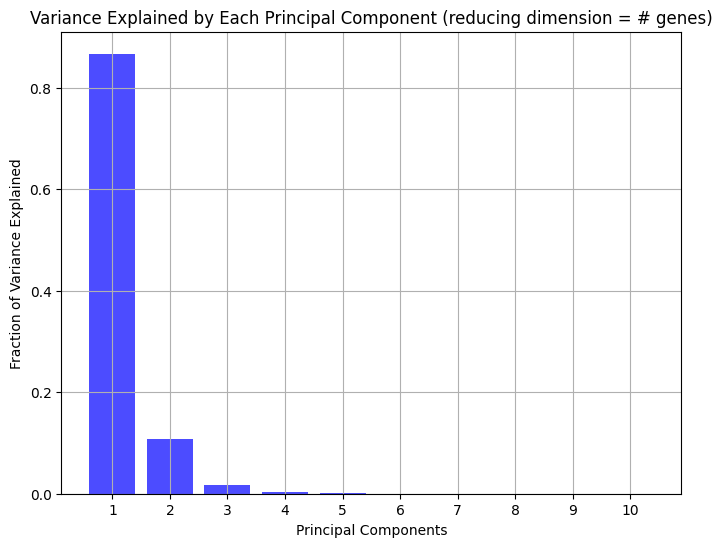

In [ ]:
# 13.2
##### 03/09/25 - PCA PLOT WHERE THE DIMENSION WE ARE REDUCING IS THE COUNTS PER GENE. #####

plt.figure(figsize=(8, 6))
plt.bar(range(1, n_PCA_Comps + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')
plt.xlabel('Principal Components')
plt.ylabel('Fraction of Variance Explained')
plt.title('Variance Explained by Each Principal Component (reducing dimension = # genes)')
plt.xticks(range(1, n_PCA_Comps + 1))
plt.grid(True)
plt.show()

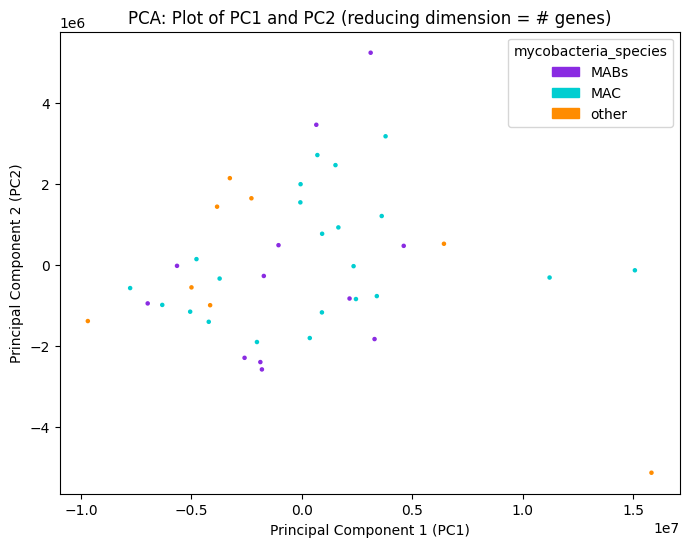

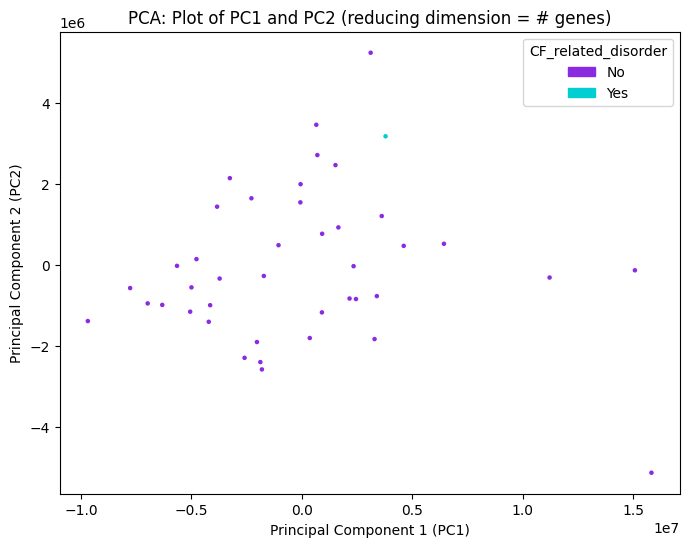

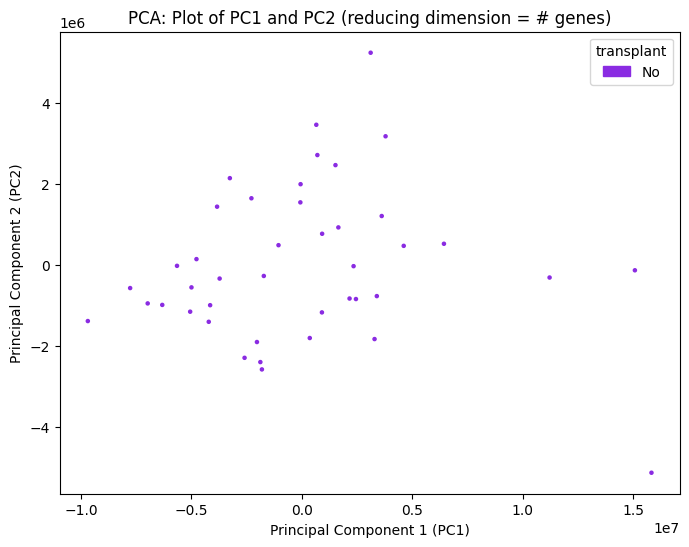

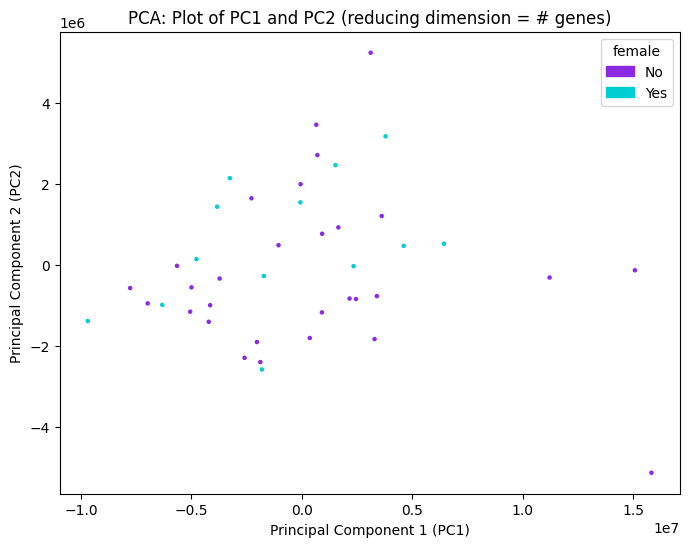

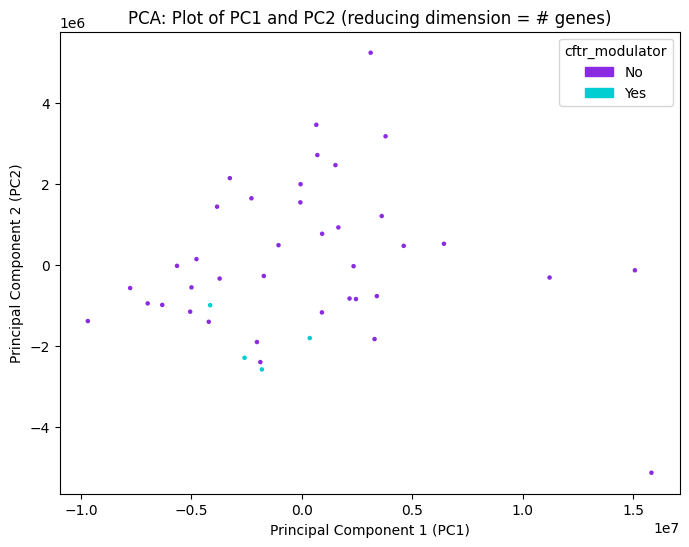

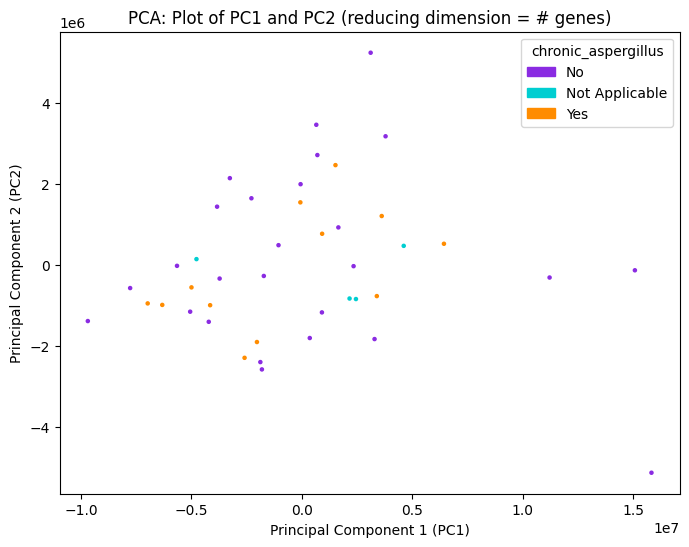

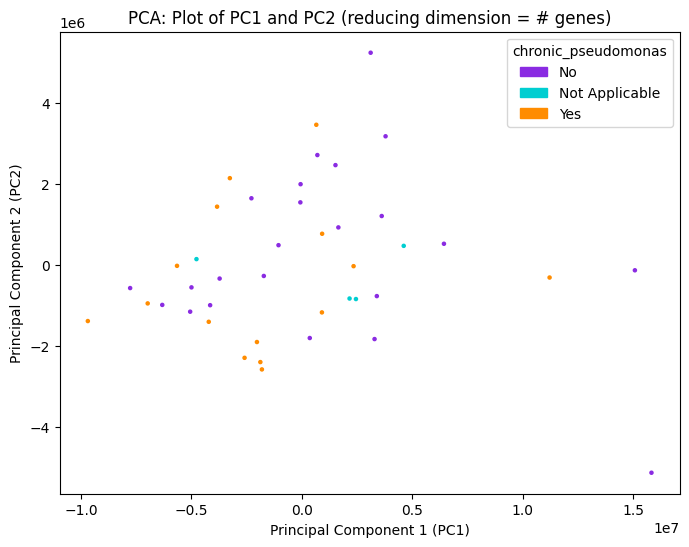

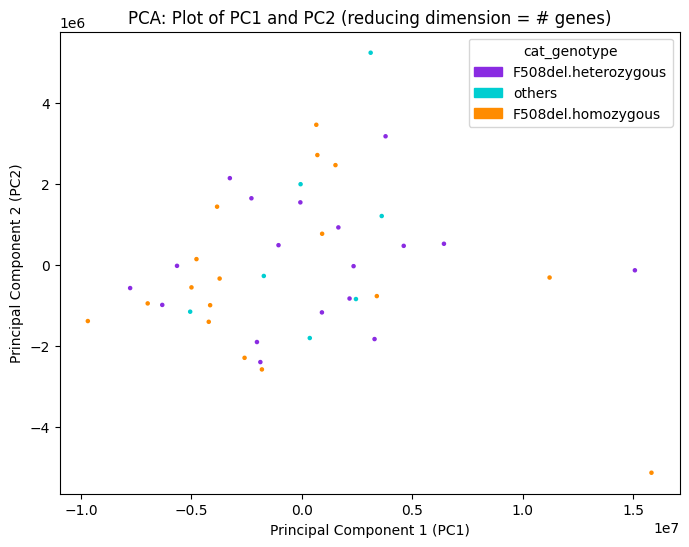

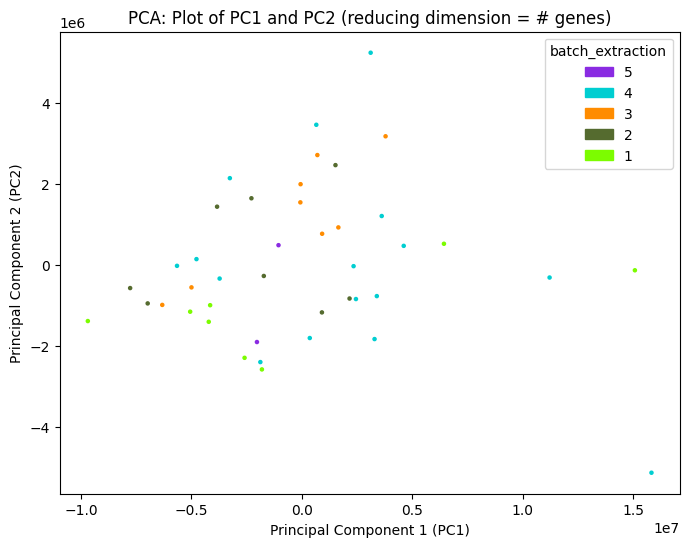

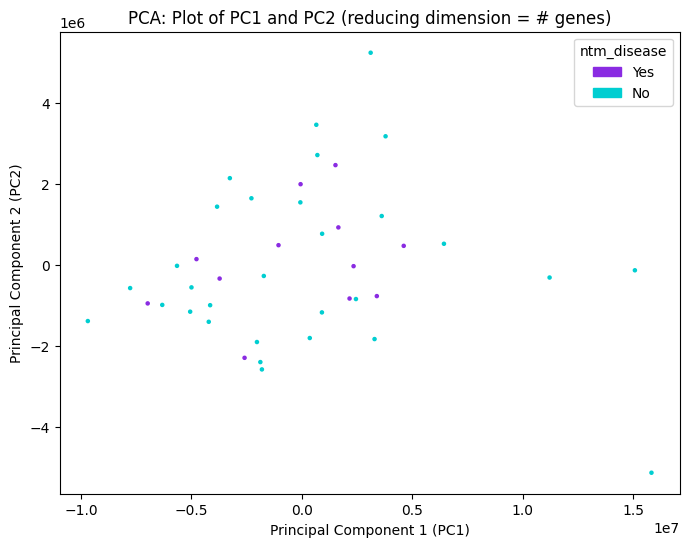

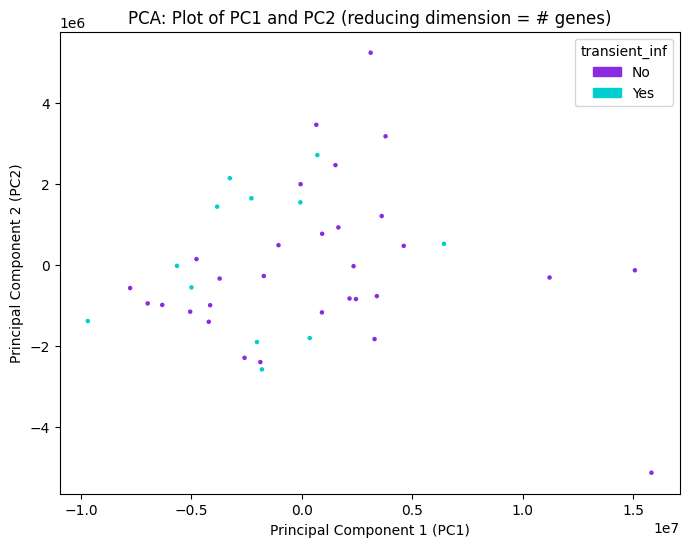

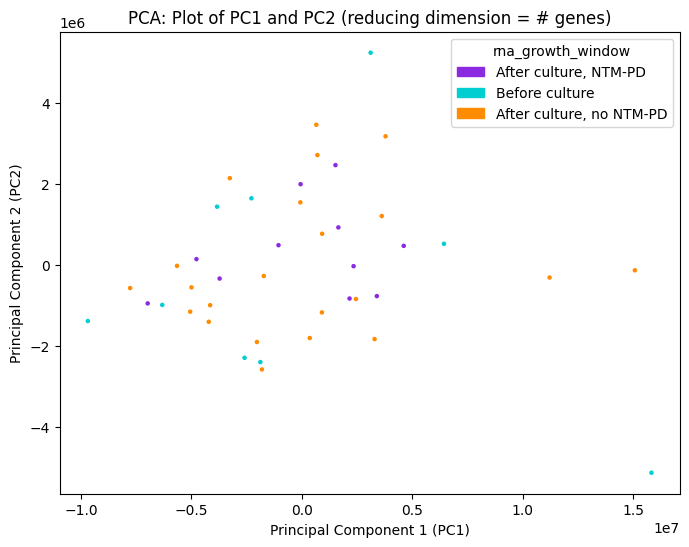

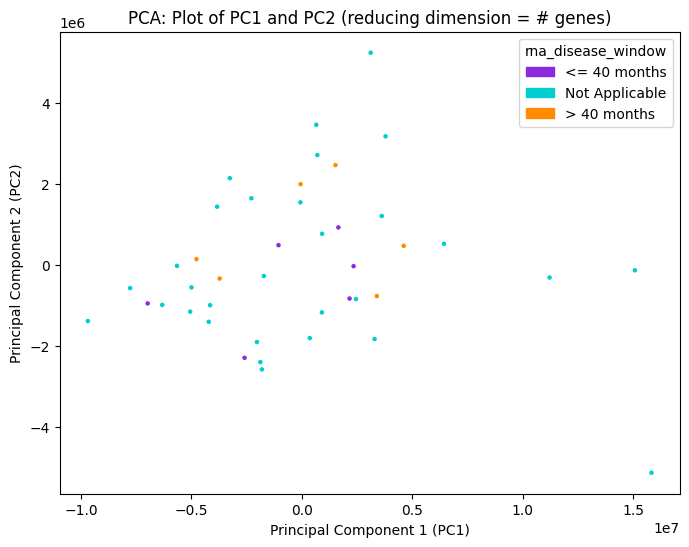

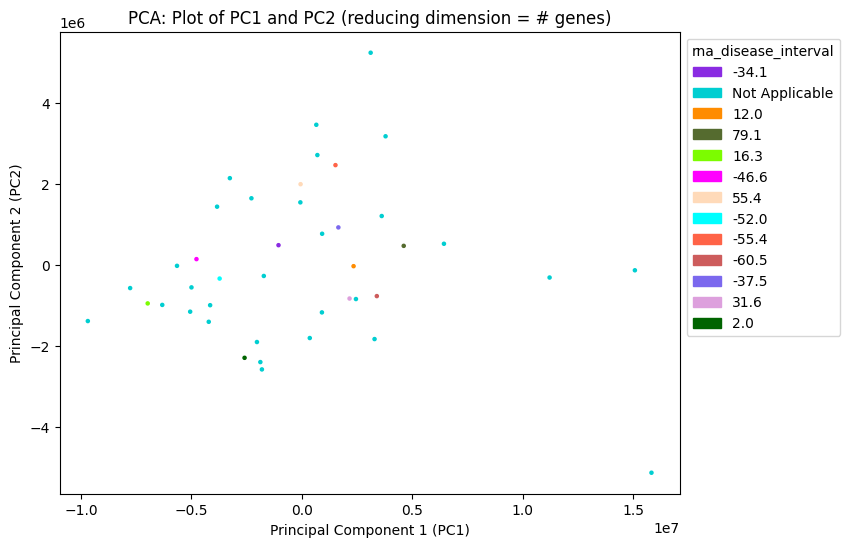

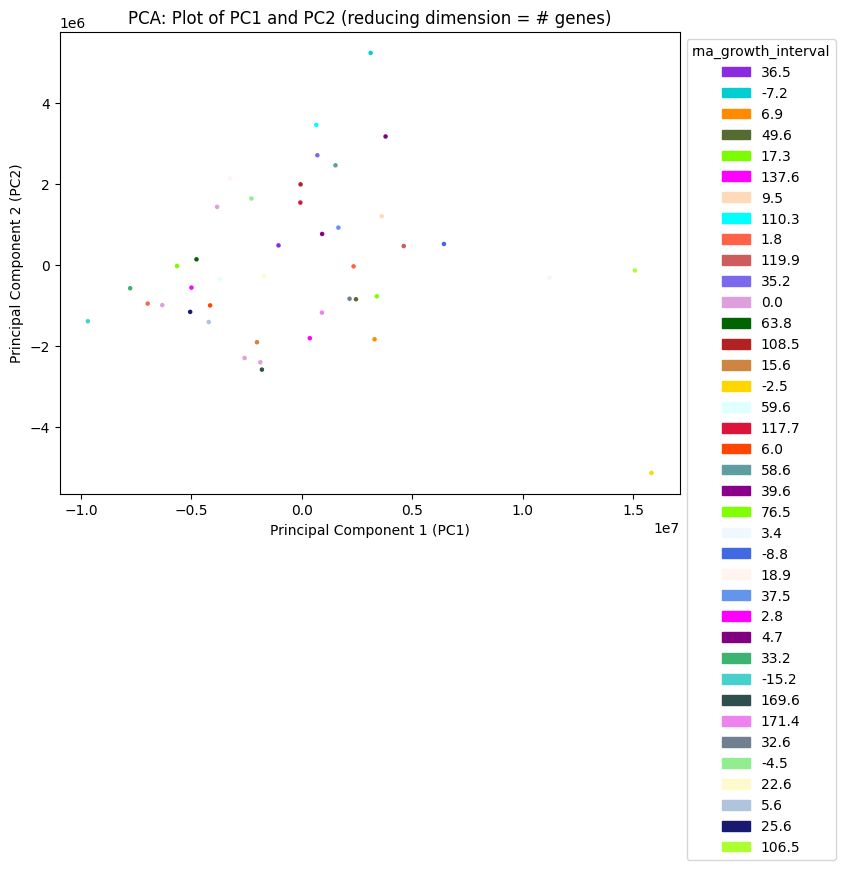

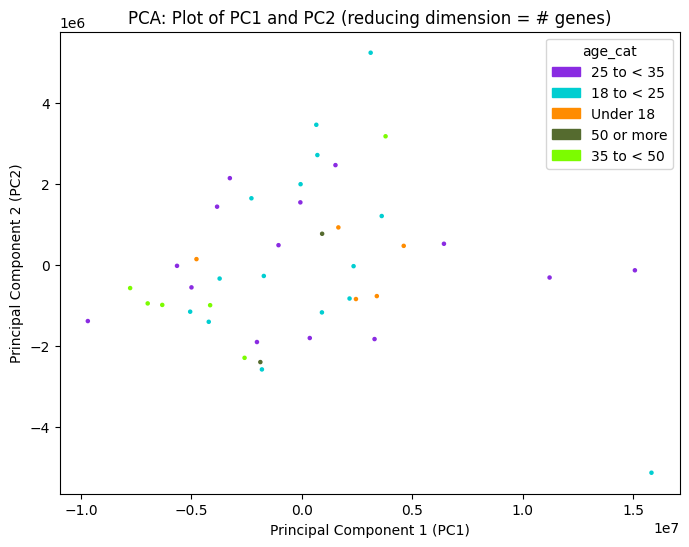

In [ ]:
# 13.4 - Trying to see if we can find a variable that correlates well with the PCA segregation, from the RNAseq metadata
##### 03/10/25

# ----------------seeking variables----------------
# load in metadata from patient RNAseq samples
RNAseq_metadata = pd.read_csv("clinical_rnaseq.csv")
RNAseq_metadata.set_index('CFB_study_id',inplace=True)

# I am most interested in coloring by:
# mycobacteria_species
# female
# cftr_modulator
# chronic_aspergillus
# chronic_pseudomonas
# batch_extraction
# rna_growth_window
# age_cat
# ---------------end seeking variables ---------------------

# -------------PCA--------------------------------
# use transposed data so that we reduce the desired dimension (genes), and keep our all of our samples (patients).
n_PCA_Comps = 10  # Number of PCs to generate 
pca = PCA(n_components=n_PCA_Comps)
principal_components = pca.fit_transform(RNAseq_data_t)
# Create a DataFrame of the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])
# ------------end PCA----------------------------

# -----------------------coloring plot by different variables---------------------------------------
# making useful list of variable factors in order that samples come in data frame (for labelling purposes).
# Also adding colors, for labeling purposes.
ordered_list_of_sample_names = RNAseq_data.columns.tolist()
RNAseq_metadata = RNAseq_metadata.reindex(index=RNAseq_data.columns.tolist())
RNAseq_metadata.fillna('Not Applicable', inplace = True)
list_of_colors = ['blueviolet', 'darkturquoise', 'darkorange', 'darkolivegreen', 'lawngreen', 'magenta', 'peachpuff', 'aqua', "tomato", "indianred", "mediumslateblue", "plum", "darkgreen", "firebrick", "peru", "gold", "lightcyan",
"crimson", "orangered", "cadetblue", "darkmagenta", "chartreuse", "aliceblue", "royalblue",
"seashell", "cornflowerblue", "fuchsia", "purple", "mediumseagreen", "mediumturquoise", "darkslategray", "violet", "slategray",
"lightgreen", "lemonchiffon", "lightsteelblue", "midnightblue", "greenyellow", "deepskyblue", "darkviolet", "yellowgreen",
"lightcoral", "lavenderblush", "darkkhaki", "papayawhip"]

## loopers

#interesting_variables = ['mycobacteria_species', 'female', 'cftr_modulator', 'chronic_aspergillus', 'chronic_pseudomonas', 'batch_extraction', 'rna_growth_window', 'age_cat']
all_variables = RNAseq_metadata.columns.tolist()

for variable in all_variables:

# assigning unique color per factor of given variable
    unique_factors = RNAseq_metadata[variable].unique()
    colors_by_factor = []
    for i in range(0, len(RNAseq_data_t)):
        for j in range(0, len(unique_factors)):
            if RNAseq_metadata[variable][i] == unique_factors[j]:
                colors_by_factor.append(list_of_colors[j])
            else:
                pass

    # turning this into legend handles
    legend_handles = []
    for j in range(0, len(unique_factors)):
        legend_handles.append(mpatches.Patch(color = list_of_colors[j], label = unique_factors[j]))

    # Adding the useful column to our PCA:
    pca_df['Color_for_plot'] = colors_by_factor

    # Plot the points in PC1 and PC2
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], marker='o', s=5, color = pca_df["Color_for_plot"])

    # Add labels and title
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.title('PCA: Plot of PC1 and PC2 (reducing dimension = # genes)')
    legend_handles = legend_handles
    plt.legend(handles=legend_handles,
            bbox_to_anchor=(1,1),
            title = variable)
    plt.show()

# seems like none of them correlate well with PCA component 1!! 



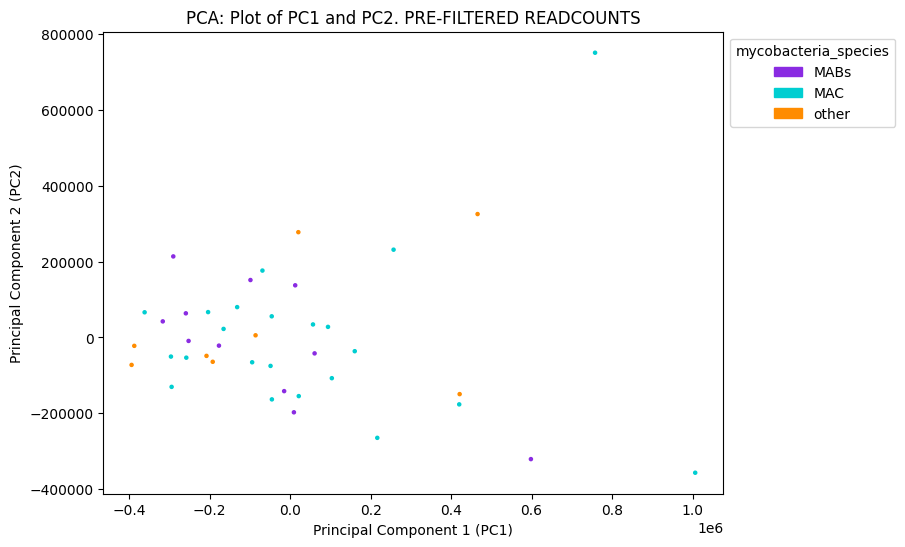

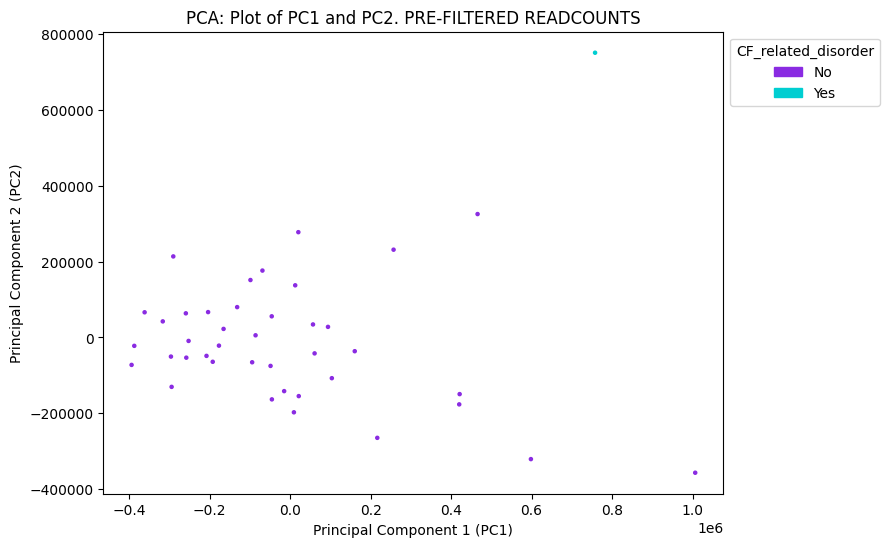

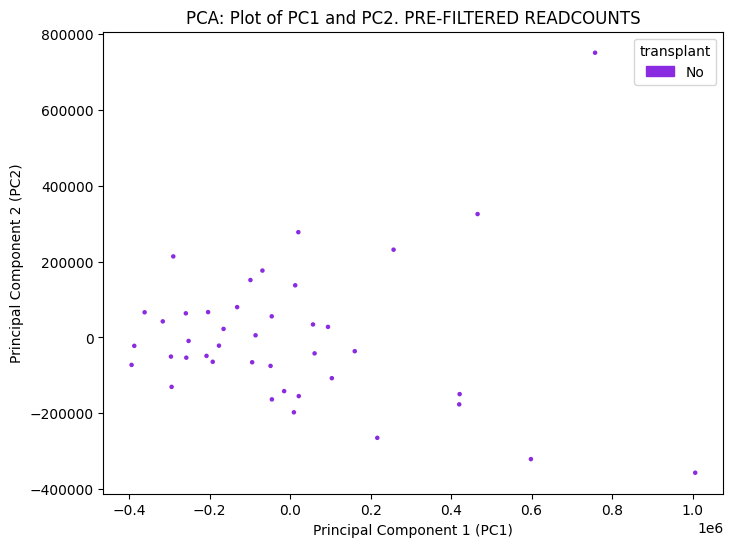

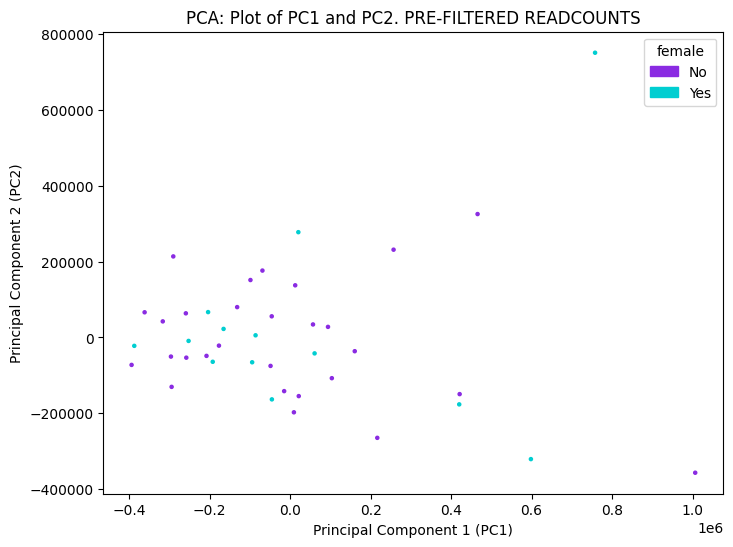

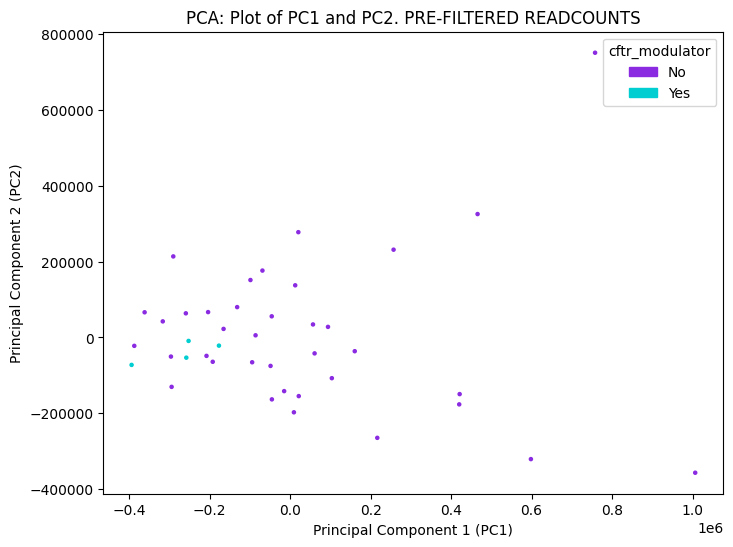

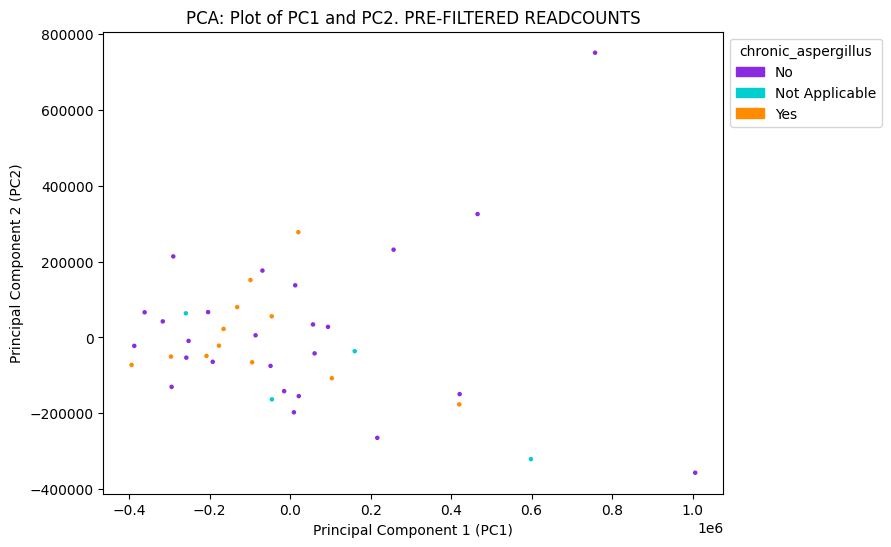

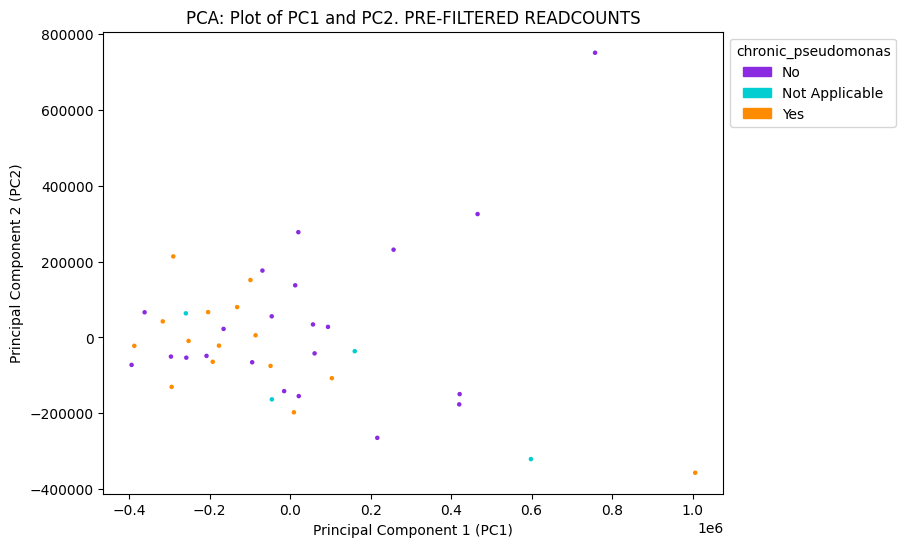

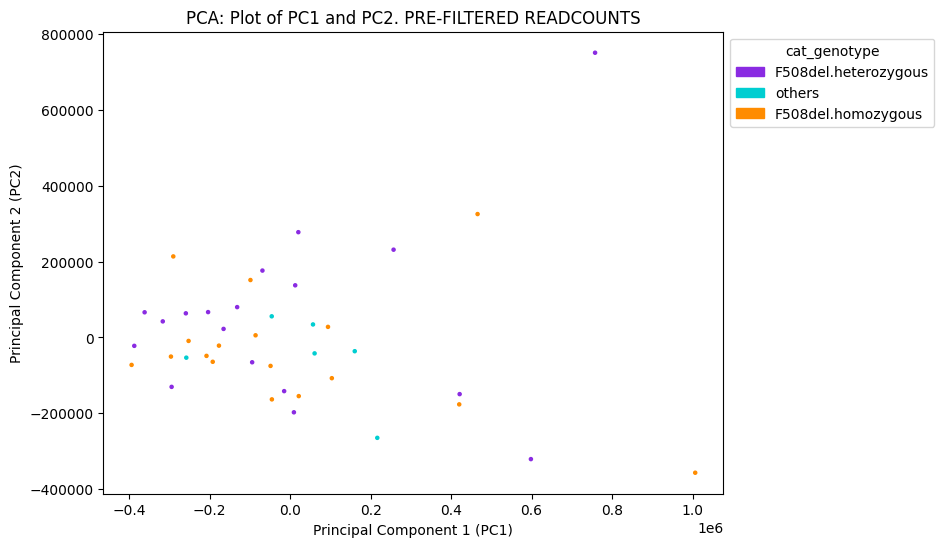

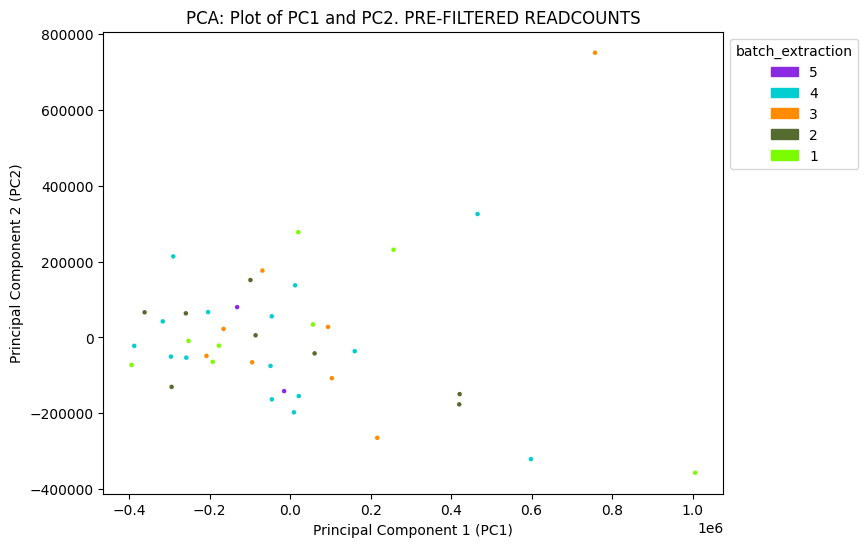

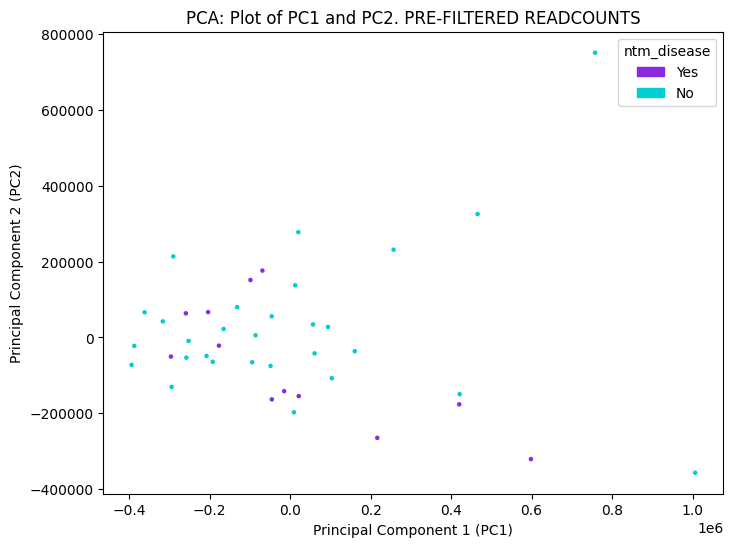

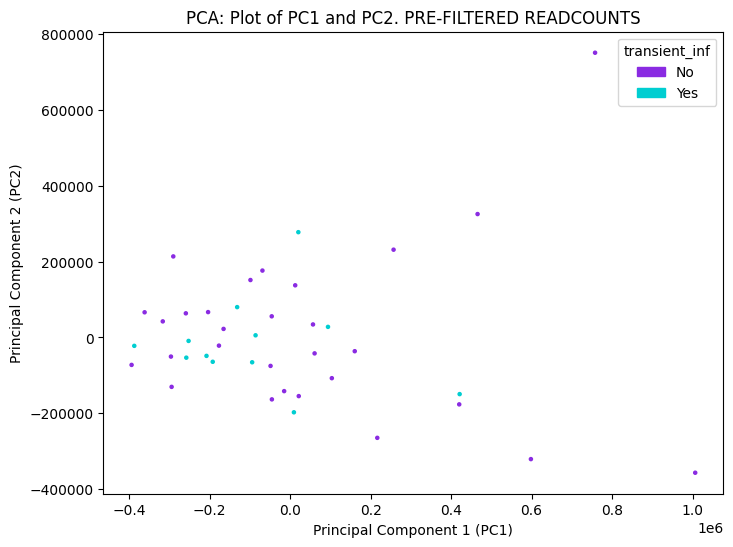

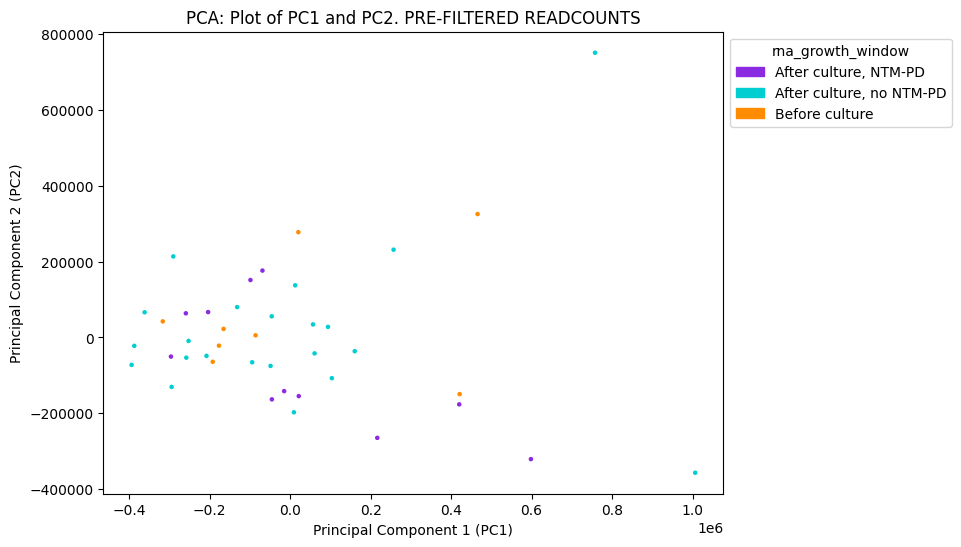

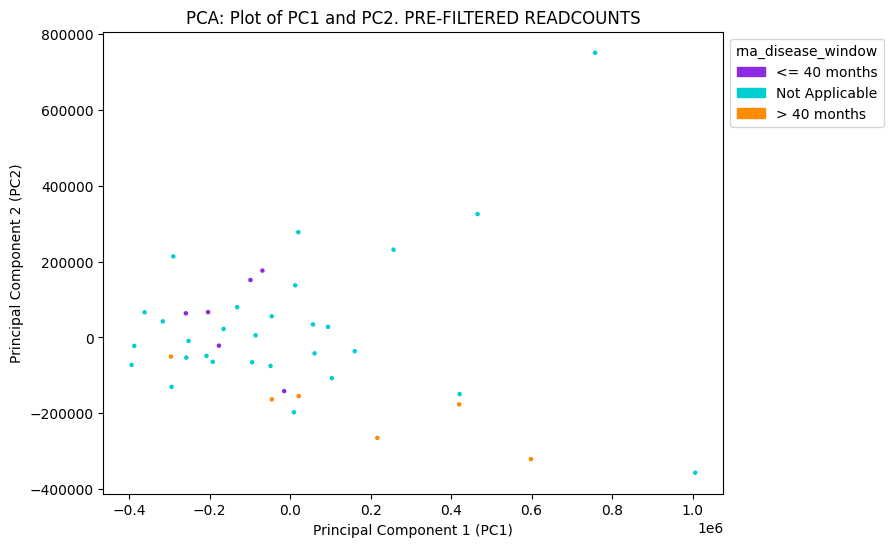

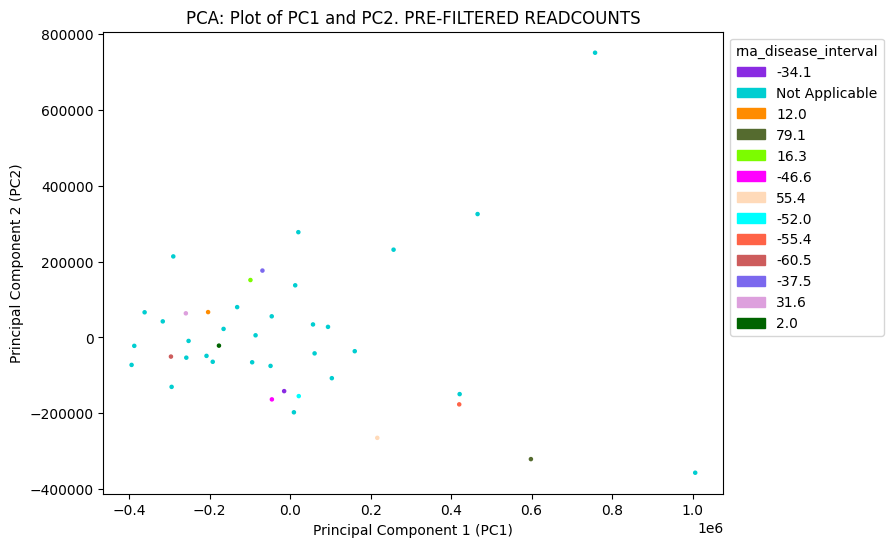

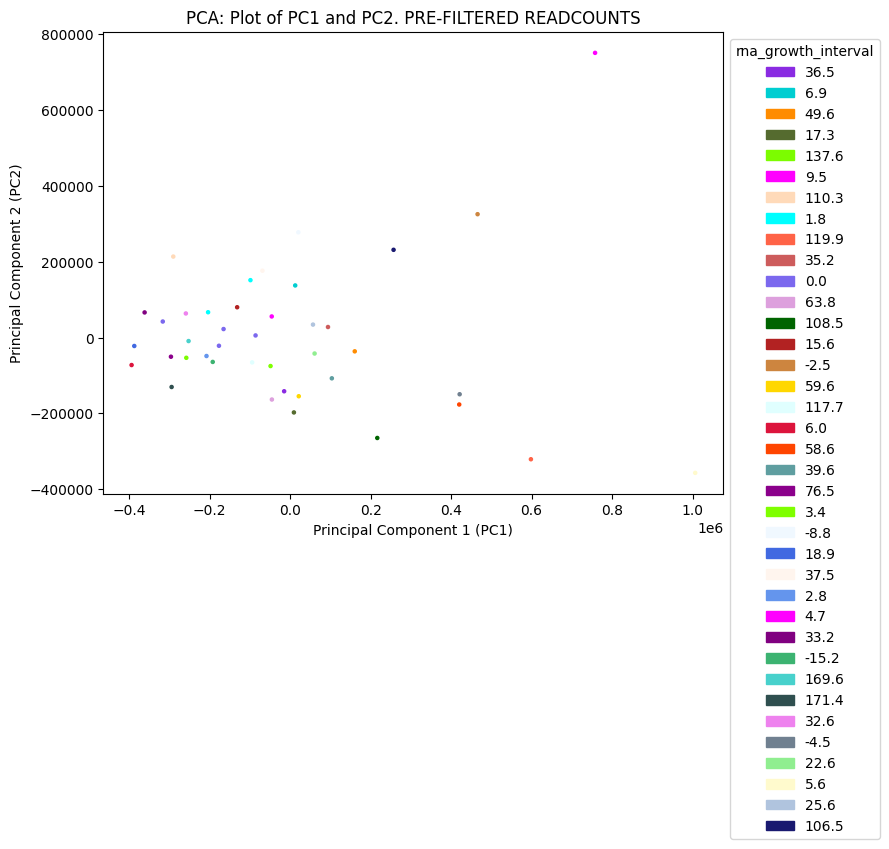

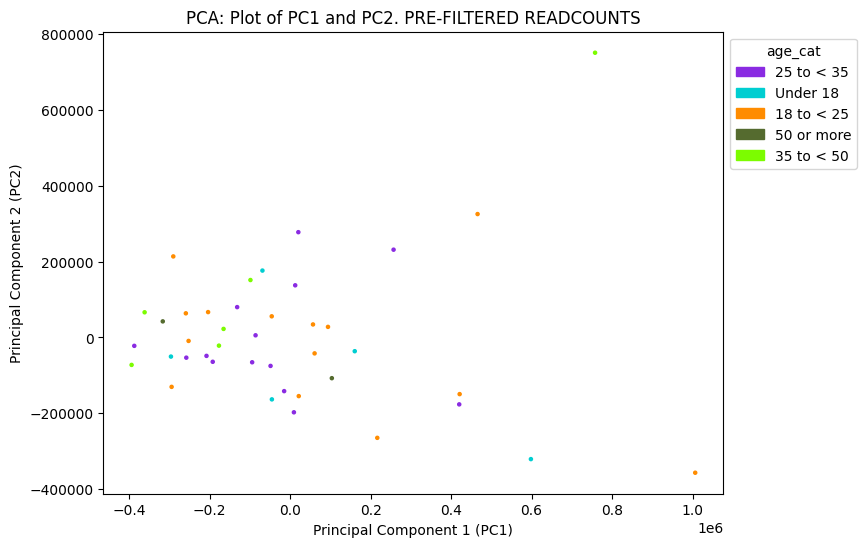

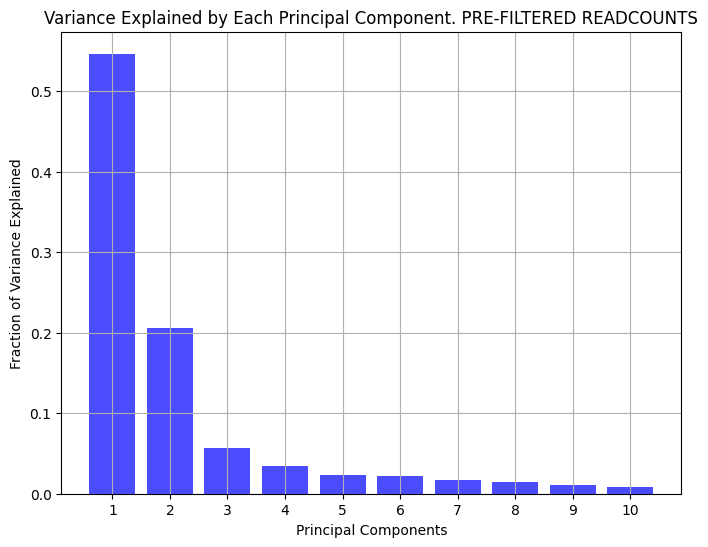

In [ ]:
# 13.5 - Same as above, but...
# Using their post-filtered dataset
##### 03/18/25

# swapping datasets

RNAseq_data = Their_DESeq_counts_data
RNAseq_data_t = Their_DESeq_counts_data.transpose()


# ----------------seeking variables----------------
# load in metadata from patient RNAseq samples
RNAseq_metadata = pd.read_csv("clinical_rnaseq.csv")
RNAseq_metadata.set_index('CFB_study_id',inplace=True)

# I am most interested in coloring by:
# mycobacteria_species
# female
# cftr_modulator
# chronic_aspergillus
# chronic_pseudomonas
# batch_extraction
# rna_growth_window
# age_cat
# ---------------end seeking variables ---------------------

# -------------PCA--------------------------------
# use transposed data so that we reduce the desired dimension (genes), and keep our all of our samples (patients).
n_PCA_Comps = 10  # Number of PCs to generate 
pca = PCA(n_components=n_PCA_Comps)
principal_components = pca.fit_transform(RNAseq_data_t)
# Create a DataFrame of the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_PCA_Comps)])
# ------------end PCA----------------------------

# -----------------------coloring plot by different variables---------------------------------------
# making useful list of variable factors in order that samples come in data frame (for labelling purposes).
# Also adding colors, for labeling purposes.
ordered_list_of_sample_names = RNAseq_data.columns.tolist()
RNAseq_metadata = RNAseq_metadata.reindex(index=RNAseq_data.columns.tolist())
RNAseq_metadata.fillna('Not Applicable', inplace = True)
list_of_colors = ['blueviolet', 'darkturquoise', 'darkorange', 'darkolivegreen', 'lawngreen', 'magenta', 'peachpuff', 'aqua', "tomato", "indianred", "mediumslateblue", "plum", "darkgreen", "firebrick", "peru", "gold", "lightcyan",
"crimson", "orangered", "cadetblue", "darkmagenta", "chartreuse", "aliceblue", "royalblue",
"seashell", "cornflowerblue", "fuchsia", "purple", "mediumseagreen", "mediumturquoise", "darkslategray", "violet", "slategray",
"lightgreen", "lemonchiffon", "lightsteelblue", "midnightblue", "greenyellow", "deepskyblue", "darkviolet", "yellowgreen",
"lightcoral", "lavenderblush", "darkkhaki", "papayawhip"]

## loopers

#interesting_variables = ['mycobacteria_species', 'female', 'cftr_modulator', 'chronic_aspergillus', 'chronic_pseudomonas', 'batch_extraction', 'rna_growth_window', 'age_cat']
all_variables = RNAseq_metadata.columns.tolist()

for variable in all_variables:

# assigning unique color per factor of given variable
    unique_factors = RNAseq_metadata[variable].unique()
    colors_by_factor = []
    for i in range(0, len(RNAseq_data_t)):
        for j in range(0, len(unique_factors)):
            if RNAseq_metadata[variable][i] == unique_factors[j]:
                colors_by_factor.append(list_of_colors[j])
            else:
                pass

    # turning this into legend handles
    legend_handles = []
    for j in range(0, len(unique_factors)):
        legend_handles.append(mpatches.Patch(color = list_of_colors[j], label = unique_factors[j]))

    # Adding the useful column to our PCA:
    pca_df['Color_for_plot'] = colors_by_factor

    # Plot the points in PC1 and PC2
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], marker='o', s=5, color = pca_df["Color_for_plot"])

    # Add labels and title
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.title('PCA: Plot of PC1 and PC2. PRE-FILTERED READCOUNTS')
    legend_handles = legend_handles
    plt.legend(handles=legend_handles,
            bbox_to_anchor=(1,1),
            title = variable)
    plt.show()

# seems like none of them correlate well with PCA component 1!! 

# 15.6
##### 03/18/25 - PERCENTAGES OF VARIABILITY: PCA PLOT WHERE THE DIMENSION WE ARE REDUCING IS THE COUNTS PER GENE. #####

plt.figure(figsize=(8, 6))
plt.bar(range(1, n_PCA_Comps + 1), pca.explained_variance_ratio_, alpha=0.7, color='b')
plt.xlabel('Principal Components')
plt.ylabel('Fraction of Variance Explained')
plt.title('Variance Explained by Each Principal Component. PRE-FILTERED READCOUNTS')
plt.xticks(range(1, n_PCA_Comps + 1))
plt.grid(True)
plt.show()

